In [1]:
# Initialize the environment
# Update: 2018-11-27

import numpy as np
import platform
import tempfile
import os
import math
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io, color
from scipy.fftpack import dct
from scipy.stats import binom
from scipy.fft import dct
import cv2
from PIL import Image

In [2]:
gaussian = io.imread('zzimg/gaussian_noise.jpg')
gaussian = color.rgb2ycbcr(cv2.cvtColor(gaussian, cv2.COLOR_BGR2RGB))

harry = io.imread('zzimg/harry.jpg')
harry = color.rgb2ycbcr(harry)

In [3]:
def BinTail(n,k,p):
    return 1-binom.cdf(k-1,n,p)

In [4]:
def NFA(nvotes,X,Y) : # on lui donne en entrée le nombre de votes pour la grille sur laquelle on veut calculer le NFA, et la taille de l'image
    p = 1/64
    n=(X*Y)/64
    nvotes2 = nvotes/64
    # Remarque : on pourrait calculer nvotes directement à l'intérieur de cette fonction, mais il faudrait lui donner la carte des votes.
    return ((X*Y*64)**2)*BinTail(n,nvotes2,p)

In [5]:
def voteMAPfast(image): 
    shape = image.shape
    X, Y = shape[:2]
    votes = np.zeros((X, Y))
    zeros = np.zeros((X, Y))
    
    for x in range(X - 7):
        for y in range(Y - 7):
            bloc = image[x:x+8, y:y+8, 0]
            cx = np.all(bloc[:, 0] == bloc[:, 0][0]) # Check constantité selon x
            cy = np.all(bloc[0, :] == bloc[0, :][0]) # Check constantité selon y
            
            if not cx or not cy:
                dctblock = dct(dct(bloc.T, norm='ortho').T, norm='ortho')
                z = np.sum(np.abs(dctblock) < 0.5)  # Compter les zéros
                
                for xx in range(x, x + 8):
                    for yy in range(y, y + 8):
                        if z > 0 and z > votes[xx, yy]:
                            if cx or cy:
                                votes[xx, yy] = -1
                            else:
                                zeros[xx, yy] = z
                                votes[xx, yy] = (x % 8 + y % 8 * 8)
    
    # Éliminer les bordures de l'image
    votes[:7, :] = -1
    votes[-7:, :] = -1
    votes[:, :7] = -1
    votes[:, -7:] = -1
    
    print("voteMAPfast terminé")
    
    return votes


In [6]:
def detectgridfast(im):
    plt.imshow(im[:,:,0])
    plt.show()
    shape = im.shape[:2]
    X, Y = shape
    votes = voteMAPfast(im)
    gridvotes = np.zeros((8, 8))

    valid_votes = votes != -1
    valid_indices = np.argwhere(valid_votes)

    for x, y in valid_indices:
        grid_idx = np.unravel_index(int(votes[x, y]), (8, 8))
        gridvotes[grid_idx] += 1

    mostvotedgrid = np.unravel_index(np.argmax(gridvotes), (8, 8))
    maxvote = gridvotes[mostvotedgrid]

    NFAv = NFA(maxvote, X, Y)

    if NFAv < 1:
        print("La grille la plus présente dans l'image est la grille de coordonnées : ",
              mostvotedgrid, " avec ", maxvote, " votes")
        print("Le NFA de cette grille est : ", NFAv)
        return mostvotedgrid, maxvote  
    else:
        print("Il n'y a pas de grille dans l'image car NFA > 1")
        return (0, 0), 0


In [7]:
def forgeries (im,X,Y) :
    forgery_n = 0
    W = 9
    used = np.zeros(X,Y)
    reg_x = []
    reg_y = []
    votes  = voteMAPfast(im)
    main_grid = detectgridfast(im)
    mask = np.zeros(X,Y)
    reg_min = math.ceil(64*2*math.log(64*X*Y)/math.log(64))
    forged_regions = np.array((reg_min,6))
    for x in range(X) :
        for y in range(Y) :
            if used[x,y] == 0 and votes[x,y] != main_grid :
                        reg_size =0
                        reg_x.append(x)
                        reg_y.append(y)
                        used[x,y] = 1
                        x0 = x
                        y0 = y
                        x1 = x
                        y1 = y
                        for u in range(reg_size) :
                            for i in range(x-W,x+W) :
                                for j in range(y-W,y+W) :
                                    if used[x,y] == 0 and votes[i,j] == votes[x,y] :
                                            reg_size += 1
                                            reg_x.append(x)
                                            reg_y.append(y)
                                            used[x+i,y+j] = 1
                                            if x0 > x :
                                                x0 = x 
                                            if y0 > y :
                                                y0 = y
                                            if x1 < x :
                                                x1 = x
                                            if y1 < y :
                                                y1 = y
                        if reg_size > reg_min :
                            k = reg_size
                            nfa = NFA(k,x1-x0,y1-y0)
                            if nfa<1 :
                                forgery_n += 1
                                forged_regions[forgery_n][0] = x0
                                forged_regions[forgery_n][1] = x1
                                forged_regions[forgery_n][2] = y0
                                forged_regions[forgery_n][3] = y1
                                forged_regions[forgery_n][4] = votes[x,y]              
                                forged_regions[forgery_n][5] = nfa
                                forgery_n += 1
                                for i in range(reg_size) :
                                     mask[reg_x[i],reg_y[i]] = 1

    kernel = np.ones((9,9), np.uint8)
    mask_final = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  
    return forged_regions, mask_final  

In [8]:
def imcolor(image):
    X = image.shape[0]
    Y = image.shape[1]
    color_map = np.random.randint(0, 255, (8, 8, 3), dtype=int)
    vote_map = voteMAPfast(image)
    new_image = np.zeros((X, Y, 3), dtype=int)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            vote = vote_map[x,y]
            if vote == -1:
                new_image[x,y] = [0, 0, 0]  # les bords et les pixels à -1 sont mis en noir
            else:
                colorpRED = color_map[np.unravel_index(int(vote), (8, 8))][0]
                colorpGREEN = color_map[np.unravel_index(int(vote), (8, 8))][1]
                colorpBLUE = color_map[np.unravel_index(int(vote), (8, 8))][2]
                new_image[x,y,0] = colorpRED
                new_image[x,y,1] = colorpGREEN
                new_image[x,y,2] = colorpBLUE
                
    return new_image

voteMAPfast terminé


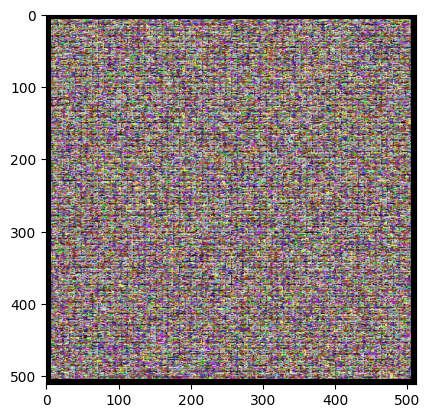

In [9]:
im=imcolor(gaussian)
plt.imshow(im)
plt.show()